# Cell 2 cell game assignment

---

# 

# Imports

#### Standard library imports

In [1]:
import sys
sys.path.append("../")

import os

#### Third party imports

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 15)
import plotly.express as px
import matplotlib.pyplot as plt
# from sklearn import metrics
import plotly.graph_objects as go
import numpy as np
import statsmodels.api as sm
from sklearn.impute import SimpleImputer

#### Local application imports

In [3]:
%load_ext autoreload
%autoreload 2

from pkg_dir.config import *
from pkg_dir.src.utils import *
from pkg_dir.src.functions import *
from pkg_dir.src.parameters import *

# 

# Loading data

In [4]:
data_path = '../pkg_dir/data/cell2cell.csv'

In [5]:
dfr = pd.read_csv(data_path)

# 

# Parameters definition

In [6]:
disc_rate = 0.09
sim_periods = 12*5
staff_cost_per_transaction = 0.02

# 

# Initial data wrangling

##### Adding RFM variables

In [7]:
## RFM variables
num_tiles = 10
dfr['rec_ntile'] = mba263.ntile(dfr['eqpdays'], num_tiles)
dfr['freq_ntile'] = num_tiles - 1 - mba263.ntile(dfr['mou'], num_tiles)
dfr['mon_ntile'] = num_tiles - 1 - mba263.ntile(dfr['recchrge'], num_tiles)

##### Setting the client ID as index

In [8]:
dfr.set_index('customer', inplace=True)

##### Filling missing values

In [9]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(dfr)
dfr[:] = imputer.transform(dfr)

##### Splitting train and test data

In [10]:
## Creating new dataframes based on `calibrat` field
df_train = dfr[dfr['calibrat'] == 1].copy()
df_test = dfr[dfr['calibrat'] == 0].copy()

## Dropping `calibrat` field
df_train.drop(['calibrat'], axis=1, inplace=True)
df_test.drop(['calibrat'], axis=1, inplace=True)

# 

# Data exploration

##### Saving summary statistics about the data as dataframe

In [11]:
dfi = dfr.describe().T
dfi.drop(['25%', '50%', '75%'], axis=1, inplace=True)

##### Evaluating number of labels in train and test set

##### Understanding the `churndep` variable

In [ ]:
dfr['calibrat'].value_counts()

In [ ]:
dfr['churndep'].value_counts()

In [ ]:
dfr.groupby(
    [
        'calibrat',
        'churndep',
    ]
).agg(
    count=('calibrat', 'count')
)

# 

# Manual models

##### 

## Model 1
### Logistic regression without RFM variables

##### Model dataset

In [12]:
dfm1_train = df_train.copy()
dfm1_test = df_test.copy()

##### Model label and features

In [13]:
## Label
m1l = 'churndep'

## Features
m1f = [
    # 'calibrat',
    # 'churn',
    # 'churndep',
    'revenue',
    'mou',
    'recchrge',
    'directas',
    'overage',
    'roam',
    'changem',
    'changer',
    'dropvce',
    'blckvce',
    'unansvce',
    'custcare',
    'threeway',
    'mourec',
    'outcalls',
    'incalls',
    'peakvce',
    'opeakvce',
    'dropblk',
    'callfwdv',
    'callwait',
    'months',
    'uniqsubs',
    'actvsubs',
    'phones',
    'models',
    'eqpdays',
    'age1',
    'age2',
    'children',
    'credita',
    'creditaa',
    'prizmrur',
    'prizmub',
    'prizmtwn',
    'refurb',
    'webcap',
    'truck',
    'rv',
    'occprof',
    'occcler',
    'occcrft',
    'occstud',
    'occhmkr',
    'occret',
    'occself',
    'ownrent',
    'marryun',
    'marryyes',
    'mailord',
    'mailres',
    'mailflag',
    'travel',
    'pcown',
    'creditcd',
    'retcalls',
    'retaccpt',
    'newcelly',
    'newcelln',
    'refer',
    'incmiss',
    'income',
    'mcycle',
    'setprcm',
    'setprc',
    'retcall',
    # 'rec_ntile',
    # 'freq_ntile',
    # 'mon_ntile',
]

##### Model training

In [14]:
m1 = logit_reg(
    a=dfm1_train[m1l],
    b=dfm1_train[m1f],
    alpha=0,
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6708450497676587
            Iterations: 201
            Function evaluations: 257
            Gradient evaluations: 201


##### Model coefficients

In [15]:
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Mba263Logit Regression Results                        
==============================================================================
Dep. Variable:               churndep   No. Observations:                40000
Model:                    Mba263Logit   Df Residuals:                    39933
Method:                           MLE   Df Model:                           66
Date:                Sun, 16 Apr 2023   Pseudo R-squ.:                 0.03218
Time:                        22:25:55   Log-Likelihood:                -26834.
converged:                       True   LL-Null:                       -27726.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1566      0.094      1.664      0.096      -0.028       0.341
revenue        0.0021      0.001      2.742      0.006       0.001       0.004
mou           -0.0003   4.87e-05     -5.278      0.000      -0.000      -0.000
recchrge      -0.0035      0.001     -4.012      0.000      -0.005      -0.002
directas      -0.0001      0.006     -0.019      0.985      -0.012       0.011
overage        0.0007      0.000      2.635      0.008       0.000       0.001
roam           0.0063      0.002      3.186      0.001       0.002       0.010
changem       -0.0005   5.28e-05     -9.156      0.000      -0.001      -0.000
changer        0.0022      0.000      5.936      0.000       0.001       0.003
dropvce        0.0135      0.006      2.341      0.019       0.002       0.025
blckvce        0.0086      0.006      1.531      0.126      -0.002       0.020
unansvce       0.0009      0.000      1.935      0.053   -1.12e-05       0.002
custcare      -0.0064      0.003     -2.491      0.013      -0.011      -0.001
threeway      -0.0297      0.011     -2.674      0.007      -0.052      -0.008
mourec         0.0001      0.000      0.934      0.350      -0.000       0.000
outcalls       0.0012      0.001      2.157      0.031       0.000       0.002
incalls       -0.0033      0.001     -3.158      0.002      -0.005      -0.001
peakvce       -0.0007      0.000     -3.391      0.001      -0.001      -0.000
opeakvce      -0.0002      0.000     -0.914      0.361      -0.001       0.000
dropblk       -0.0055      0.005     -0.998      0.318      -0.016       0.005
callfwdv       0.0025      0.022      0.117      0.907      -0.040       0.045
callwait       0.0025      0.003      0.799      0.424      -0.004       0.009
months        -0.0219      0.002    -11.133      0.000      -0.026      -0.018
uniqsubs       0.1850      0.020      9.380      0.000       0.146       0.224
actvsubs      -0.1952      0.027     -7.131      0.000      -0.249      -0.142
phones         0.0484      0.018      2.696      0.007       0.013       0.084
models         0.0147      0.028      0.533      0.594      -0.039       0.069
eqpdays        0.0015   7.36e-05     20.086      0.000       0.001       0.002
age1          -0.0038      0.001     -4.462      0.000      -0.005      -0.002
age2          -0.0012      0.001     -1.713      0.087      -0.002       0.000
children       0.0952      0.028      3.395      0.001       0.040       0.150
credita       -0.1568      0.035     -4.478      0.000      -0.225      -0.088
creditaa      -0.3443      0.034    -10.131      0.000      -0.411      -0.278
prizmrur       0.0692      0.049      1.410      0.159      -0.027       0.165
prizmub       -0.0381      0.024     -1.579      0.114      -0.085       0.009
prizmtwn       0.0427      0.031      1.372      0.170      -0.018       0.104
refurb         0.2331      0.032      7.386      0.000       0.171       0.295
webcap        -0.1465      0.037     -3.946      0.000      -0.219      -0.074
tr

In [16]:
dfm1_or = odds_ratios(m1)
dfm1_or

,Odds ratios,std err,z,P>|z|,[0.025,0.975]
revenue,1.002140,0.000781,2.738914,0.006,1.000624,1.003655
mou,0.999743,0.000049,5.278355,0.000,0.999649,0.999838
recchrge,0.996512,0.000868,4.019382,0.000,0.994828,0.998195
directas,0.999892,0.005822,0.018629,0.985,0.988596,1.011187
overage,1.000721,0.000274,2.634484,0.008,1.000190,1.001252
...,...,...,...,...,...,...
income,0.986343,0.005926,2.304438,0.021,0.974846,0.997840
mcycle,1.129911,0.100176,1.296829,0.195,0.935570,1.324252
setprcm,0.899031,0.035954,2.808258,0.005,0.829280,0.968782
setprc,1.000641,0.000279,2.297988,0.022,1.000100,1.001182


In [17]:
## Adding the standard deviation column to the odds ratios dataframe
dfm1_or['std'] = dfm1_test[m1f].std()

## Operation between resulting odds ratios and standard deviation
dfm1_or['norm_or'] = np.power(dfm1_or['Odds ratios'], dfm1_or['std'])

## Correcting odds ratios that are lower than one
dfm1_or['norm_or'] = dfm1_or['norm_or'].apply(lambda x: 1/x if x < 1 else x)

## Ranking results
dfm1_or['rank'] = dfm1_or['norm_or'].rank(ascending=False)
dfm1_or.sort_values(by='rank', inplace=True, ascending=True)

##### Predictions

In [18]:
## Churn predicted probability
dfm1_test['m1_pred_prob'] = m1.predict(dfm1_test[m1f])

## Classifying churners in groups
dfm1_test['m1_pred_prob_grade'] = 10 - ntile(dfm1_test['m1_pred_prob'], 10)

### 

## Model 2
### Logistic regression without RFM variables

##### Model dataset

In [19]:
dfm2_train = df_train.copy()
dfm2_test = df_test.copy()

##### Model label and features

In [20]:
## Label
m2l = 'churndep'

## Features
m2f = [
    # 'calibrat',
    # 'churn',
    # 'churndep',
    'revenue',
    'mou',
    'recchrge',
    'directas',
    'overage',
    'roam',
    'changem',
    'changer',
    'dropvce',
    'blckvce',
    'unansvce',
    'custcare',
    'threeway',
    'mourec',
    'outcalls',
    'incalls',
    'peakvce',
    'opeakvce',
    'dropblk',
    'callfwdv',
    'callwait',
    'months',
    'uniqsubs',
    'actvsubs',
    'phones',
    'models',
    'eqpdays',
    'age1',
    'age2',
    'children',
    'credita',
    'creditaa',
    'prizmrur',
    'prizmub',
    'prizmtwn',
    'refurb',
    'webcap',
    'truck',
    'rv',
    'occprof',
    'occcler',
    'occcrft',
    'occstud',
    'occhmkr',
    'occret',
    'occself',
    'ownrent',
    'marryun',
    'marryyes',
    'mailord',
    'mailres',
    'mailflag',
    'travel',
    'pcown',
    'creditcd',
    'retcalls',
    'retaccpt',
    'newcelly',
    'newcelln',
    'refer',
    'incmiss',
    'income',
    'mcycle',
    'setprcm',
    'setprc',
    'retcall',
    # 'rec_ntile',
    # 'freq_ntile',
    # 'mon_ntile',
]

##### Model training

In [21]:
m2 = sm.Logit(
    dfm2_train[m1l],
    dfm2_train[m1f],
).fit()

Optimization terminated successfully.
         Current function value: 0.670879
         Iterations 5


##### Model coefficients

In [22]:
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               churndep   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39934
Method:                           MLE   Df Model:                           65
Date:                Sun, 16 Apr 2023   Pseudo R-squ.:                 0.03213
Time:                        22:25:56   Log-Likelihood:                -26835.
converged:                       True   LL-Null:                       -27726.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
revenue        0.0022      0.001      2.792      0.005       0.001       0.004
mou           -0.0003   4.87e-05     -5.262      0.000      -0.000      -0.000
recchrge      -0.0033      0.001     -3.845      0.000      -0.005      -0.002
directas      -0.0005      0.006     -0.092      0.927      -0.012       0.011
overage        0.0007      0.000      2.635      0.008       0.000       0.001
roam           0.0063      0.002      3.163      0.002       0.002       0.010
changem       -0.0005   5.28e-05     -9.159      0.000      -0.001      -0.000
changer        0.0022      0.000      5.939      0.000       0.001       0.003
dropvce        0.0135      0.006      2.338      0.019       0.002       0.025
blckvce        0.0087      0.006      1.545      0.122      -0.002       0.020
unansvce       0.0009      0.000      1.989      0.047    1.27e-05       0.002
custcare      -0.0062      0.003     -2.434      0.015      -0.011      -0.001
threeway      -0.0299      0.011     -2.690      0.007      -0.052      -0.008
mourec         0.0001      0.000      0.900      0.368      -0.000       0.000
outcalls       0.0012      0.001      2.124      0.034     9.5e-05       0.002
incalls       -0.0034      0.001     -3.223      0.001      -0.005      -0.001
peakvce       -0.0008      0.000     -3.503      0.000      -0.001      -0.000
opeakvce      -0.0002      0.000     -0.792      0.428      -0.001       0.000
dropblk       -0.0055      0.006     -1.000      0.317      -0.016       0.005
callfwdv       0.0023      0.022      0.108      0.914      -0.040       0.045
callwait       0.0022      0.003      0.698      0.485      -0.004       0.008
months        -0.0214      0.002    -11.011      0.000      -0.025      -0.018
uniqsubs       0.1861      0.020      9.441      0.000       0.147       0.225
actvsubs      -0.1895      0.027     -6.980      0.000      -0.243      -0.136
phones         0.0483      0.018      2.691      0.007       0.013       0.083
models         0.0225      0.027      0.831      0.406      -0.031       0.076
eqpdays        0.0015   7.29e-05     20.523      0.000       0.001       0.002
age1          -0.0034      0.001     -4.178      0.000      -0.005      -0.002
age2          -0.0012      0.001     -1.837      0.066      -0.003    8.31e-05
children       0.0967      0.028      3.448      0.001       0.042       0.152
credita       -0.1490      0.035     -4.294      0.000      -0.217      -0.081
creditaa      -0.3366      0.034     -9.996      0.000      -0.403      -0.271
prizmrur       0.0752      0.049      1.538      0.124      -0.021       0.171
prizmub       -0.0359      0.024     -1.493      0.135      -0.083       0.011
prizmtwn       0.0463      0.031      1.489      0.136      -0.015       0.107
refurb         0.2392      0.031      7.635      0.000       0.178       0.301
webcap        -0.1208      0.034     -3.583      0.000      -0.187      -0.055
truck          0.0332      0.036      0.928      0.354      -0.037       0.103
rv

In [23]:
dfm2_or = odds_ratios(m2)
dfm2_or

,Odds ratios,std err,z,P>|z|,[0.025,0.975]
mou,0.999744,0.000049,5.262881,0.000,0.999650,0.999838
recchrge,0.996679,0.000862,3.851049,0.000,0.995006,0.998352
directas,0.999468,0.005814,0.091540,0.927,0.988189,1.010747
overage,1.000721,0.000274,2.634221,0.008,1.000190,1.001252
roam,1.006304,0.001999,3.153384,0.002,1.002426,1.010183
...,...,...,...,...,...,...
income,0.988955,0.005731,1.927230,0.054,0.977838,1.000073
mcycle,1.130841,0.100268,1.304919,0.192,0.936322,1.325361
setprcm,0.924232,0.033626,2.253277,0.024,0.858998,0.989466
setprc,1.000757,0.000270,2.803526,0.005,1.000233,1.001281


In [24]:
## Adding the standard deviation column to the odds ratios dataframe
dfm2_or['std'] = dfm2_test[m2f].std()

## Operation between resulting odds ratios and standard deviation
dfm2_or['norm_or'] = np.power(dfm2_or['Odds ratios'], dfm2_or['std'])

## Correcting odds ratios that are lower than one
dfm2_or['norm_or'] = dfm2_or['norm_or'].apply(lambda x: 1/x if x < 1 else x)

## Ranking results
dfm2_or['rank'] = dfm2_or['norm_or'].rank(ascending=False)
dfm2_or.sort_values(by='rank', inplace=True, ascending=True)

##### Predictions

In [25]:
## Churn predicted probability
dfm2_test['m2_pred_prob'] = m1.predict(dfm2_test[m1f])

## Classifying churners in groups
dfm2_test['m2_pred_prob_grade'] = 10 - ntile(dfm2_test['m2_pred_prob'], 10)

## 

## Manual models compilation

In [26]:
## Models objects
models = {
    
    ## 
    'm1': { 
        'df_test': dfm1_test,
        'label': m1l,
        'features': m1f,
        'model': m1,
    },
    
    ## 
    'm2': { 
        'df_test': dfm2_test,
        'label': m2l,
        'features': m2f,
        'model': m2,
    },
    
}

# 

# Evaluating models

##### Lift

In [ ]:
fig = go.Figure()


for model_key in models:
    
    ## Variables definition
    mx_info = models[model_key]
    dfx = mx_info['df_test']
    
    ## Gain calculation
    mx_gain = mba263.lift(dfx['churn'], dfx[model_key + '_pred_prob'], bins=100)

    fig.add_trace(
        go.Scatter(
            x=np.linspace(0, 100, num=mx_gain.shape[0]), 
            y=mx_gain,
            mode='lines',
            name=model_key
        )
    )
    

fig.update_layout(
    width=700, height=500,
    title='Lift curves'
)
    
fig.show()

# 

# Identifying customers that will receive promotion

## Generating dataset of selected customers

In [27]:
dfc = dfm2_test[dfm2_test['m2_pred_prob_grade'] == 1].copy()

In [28]:
## Average churn of selected customers
avg_churn = dfc['churn'].mean()

## Understanding customer selection

##### Do customers with a refurbished handset own a cheaper handset?
- It seems that refurbished handsets are actually more expensive

In [ ]:
dfc.loc[:, rc].groupby(
    'refurb',
).agg(
    count=('setprc', 'count'),
    mean_price=('setprc', 'mean')
)

In [ ]:
rc = [
    'setprc',
    'refurb',
]

dfc.loc[:, rc]

px.histogram(
    data_frame=dfc.loc[:, rc],
    x='setprc',
    color='refurb',
    histnorm='probability',
    marginal='rug',
)

In [ ]:
dfc.loc[:, rc]

px.box(
    data_frame=dfc.loc[:, rc],
    x='setprc',
    color='refurb',
)

##### How does the `eqpdays` variable behaves?

In [ ]:
## Box plot with variable distribution
px.box(
    x=dfc.loc[:, 'eqpdays'],
)

In [ ]:
## Number of customer above a given percentile
ths_q = 0.75
ths_n = dfc.loc[:, 'eqpdays'].quantile(ths_q)

mr1 = dfc['eqpdays'] >= ths_n

dfc.loc[mr1, 'eqpdays']

##### Question...

# 

# Profit calculations

## Profit calculations without intervention

In [29]:
## Function to calculate status quo expected value
def status_quo_exp_profit(periods, revenue, cost, churn_p, disc):
    
    ### List where all the results will be stored
    res_lst = []
    
    ### Iterating over all periods and calculating individual results
    for p in np.linspace(0, periods, periods + 1):
        
        res_lst.append(
            ((revenue - cost)*(1 - churn_p)**p)*(1 - disc)**p
        )
    
    ### Adding and rounding all results stored
    res = round(sum(res_lst), 2)
    
    return res

In [30]:
## Expected profits (present value) for each customer if we don't do anything
dfc['exp_pv_profit_no_inc'] = dfc.apply(
    lambda x: status_quo_exp_profit(
        sim_periods, 
        x['revenue'], 
        0,
        x['m2_pred_prob'],
        disc_rate,
    ), 
    axis=1
)

## 

## Profit calculations with intervention

### Function to estimate the new churn probability and cost of an applied promotion

In [31]:
## Function to calculate the churn probability for each incentive
def inc_pp_and_cost(dfc, ftr, prom):
    """
    Function to calculate the churn probability for each incentive
    
    param dfc (dataframe): dataframe with all customers that are in 1st decile top churners
    param ftr (series): series with booleans related to filtering conditions for a give promotion
    param prom (string): name of the promotion applied
    
    return: NaN
    """
    
    
    ## Creating copy of the row with the modified fields
    dfx = dfc.loc[ftr, :].copy()
    
    
    ## Adjusting features based on the promotions applied
    
    ### Monthly Usage Discount
    if prom == 'Monthly Usage Discount':

        #### Adjusting features based on the promotions applied
        dfx.loc[ftr, 'mou'] = dfx.loc[ftr, 'mou'].quantile(0.8) 
        
        #### Registering the cost of the incentive
        dfc.loc[ftr, 'prom_cost'] = dfc.loc[ftr, 'recchrge']*0.25
    
    ### New Phone
    elif prom == 'New Phone':
    
        #### Adjusting features based on the promotions applied
        dfx.loc[ftr, 'eqpdays'] = 0
        dfx.loc[ftr, 'refurb'] = 0
        dfx.loc[ftr, 'webcap'] = 1
        dfx.loc[ftr, 'setprc'] = np.maximum(dfx.loc[ftr, 'setprc'], 81.85)
        
        #### Registering the cost of the incentive
        dfc.loc[ftr, 'prom_cost'] = np.maximum(dfc.loc[ftr, 'setprc'], 81.85)*0.1
        
    ### Prune Inactive Users
    elif prom == 'Prune Inactive Users':
        
        #### Adjusting features based on the promotions applied
        dfx.loc[ftr, 'uniqsubs'] = dfx.loc[ftr, 'actvsubs']
        
        #### Registering the cost of the incentive
        dfc.loc[ftr, 'prom_cost'] = (dfc.loc[ftr, 'uniqsubs'] - dfc.loc[ftr, 'actvsubs'])*staff_cost_per_transaction
    
    
    ## Estimating the new churn probability with the new parameters
    pp = m2.predict(dfx.loc[ftr, m2f])
    
    ## Adding the predicted probabilities to the original dataframe
    dfc.loc[ftr, 'prom_pred_prob'] = pp
    
    
    return 

### Customer selection criteria for each promotion

In [32]:
## Promotions dictionary
proms = {
    
    
    ## Selecting out clients who might have lower churn if they get inactive users removed
    'Prune Inactive Users': {
        'selection': (dfc['uniqsubs'] - dfc['actvsubs'] > 0)
    },
    
    ## 
    'Monthly Usage Discount': { 
        'selection': (dfc['mou'] < dfc['mou'].quantile(0.8))
    },
    
    ## Selecting out clients who might have lower churn if they get a new device
    'New Phone': { 
        'selection': ((dfc['refurb'] == 1) | (dfc['eqpdays'] >= dfc['eqpdays'].quantile(0.75)) | (dfc['webcap'] == 0))
    },
    
}

In [33]:
## Creating empty column that then will be overwritten with the different promotions
dfc['prom_sel'] = 'no_promotion'
dfc['prom_pred_prob'] = dfc['m2_pred_prob'] 
dfc['prom_cost'] = 0

## Tagging all customer that fall under a certain promotion selection criteria and calculating new churn probability
for prom in proms:
    
    dfc.loc[proms[prom]['selection'], 'prom_sel'] = prom
    
    inc_pp_and_cost(dfc, proms[prom]['selection'], prom)

In [34]:
dfc['prom_sel'].value_counts(normalize=True)

New Phone                 0.622544
Monthly Usage Discount    0.255717
no_promotion              0.085024
Prune Inactive Users      0.036715
Name: prom_sel, dtype: float64

In [35]:
dfc[dfc['prom_sel'] == 'no_promotion']

,churn,churndep,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,credita,creditaa,prizmrur,prizmub,prizmtwn,refurb,webcap,truck,rv,occprof,occcler,occcrft,occstud,occhmkr,occret,occself,ownrent,marryun,marryyes,mailord,mailres,mailflag,travel,pcown,creditcd,retcalls,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall,rec_ntile,freq_ntile,mon_ntile,m2_pred_prob,m2_pred_prob_grade,exp_pv_profit_no_inc,prom_sel,prom_pred_prob,prom_cost
customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000332,0.0,0.5,111.38500,767.25,75.000000,7.4250,0.00,0.000000,-243.250000,2.655000,8.000000,0.333333,23.333334,0.333333,0.000000,154.616670,35.333332,0.000000,170.000000,81.000000,8.333333,0.0,0.333333,48.0,1.0,1.0,3.0,3.0,664.0,60.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,9.989998,1.0,8.0,2.0,1.0,0.609985,1,172.67,no_promotion,0.609985,0.0
1000954,0.0,0.5,105.56750,815.00,70.000000,3.4650,44.00,17.077499,270.000000,20.652500,13.333333,2.000000,16.666666,0.666667,0.333333,316.686680,29.000000,9.000000,144.000000,95.333336,15.333333,0.0,0.666667,45.0,1.0,1.0,7.0,3.0,552.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,129.989990,1.0,7.0,2.0,1.0,0.661076,1,152.65,no_promotion,0.661076,0.0
1002457,0.0,0.5,479.09000,2411.25,159.990010,0.9900,233.25,292.537510,-1798.250000,-107.640000,22.333334,1.000000,7.000000,0.000000,0.000000,687.226680,116.000000,29.333334,312.333340,200.666670,23.333334,0.0,0.666667,40.0,1.0,1.0,7.0,4.0,286.0,40.0,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,0.0,0.0,79.989990,0.0,4.0,0.0,0.0,0.909894,1,521.88,no_promotion,0.909894,0.0
1002461,0.0,0.5,152.75999,1824.75,94.989998,13.6125,168.25,0.097500,527.250000,-24.610001,11.000000,16.666666,120.666660,3.333333,0.000000,489.183320,109.000000,59.333332,326.666660,257.666660,28.000000,0.0,15.000000,40.0,1.0,1.0,24.0,15.0,48.0,30.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,239.989990,1.0,0.0,0.0,0.0,0.608684,1,237.24,no_promotion,0.608684,0.0
1002558,0.0,0.5,297.91000,1122.75,59.990002,0.0000,512.50,33.709999,67.250000,11.500000,14.666667,22.666666,46.333332,0.000000,0.000000,315.286650,35.000000,5.333334,287.000000,58.333332,37.333332,0.0,16.000000,38.0,1.0,1.0,3.0,3.0,111.0,44.0,40.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,9.989998,1.0,1.0,1.0,2.0,0.689711,1,415.13,no_promotion,0.689711,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080501,1.0,0.5,279.47501,1817.25,54.990002,0.2475,669.25,0.000000,-1725.250000,-233.495000,6.666666,4.333334,36.666668,16.000000,0.000000,960.710020,10.333333,0.666667,99.333336,99.666664,11.000000,0.0,2.333333,13.0,1.0,1.0,1.0,1.0,377.0,54.0,54.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.000000,0.0,5.0,0.0,2.0,0.639678,1,415.82,no_promotion,0.639678,0.0
1084226,1.0,0.5,70.49250,720.50,59.990002,0.0000,29.00,4.780000,-625.500000,-20.112499,19.000000,1.666667,78.666664,0.000000,0.000000,157.480000,79.333336,16.333334,159.333330,198.333330,20.666666,0.0,7.

In [36]:
dfc['prom_cost'].value_counts()

8.185000     1710
0.000000      266
7.497500      113
14.998999     102
0.020000       68
             ... 
3.225000        1
3.708125        1
4.636250        1
3.264166        1
1.814375        1
Name: prom_cost, Length: 249, dtype: int64

### Calculating expected profits related to each intervention

In [37]:
## Function to calculate expected value for each promotion
def prom_exp_profit(periods, revenue, cost, churn_p_sq, churn_p_prom, disc):
    
    ### List where all the results will be stored
    res_lst = []
    
    ### Iterating over all periods and calculating individual results
    for p in np.linspace(0, periods, periods + 1):
        
        ## Entry for t and t+1
        if p <= 1:
            res_lst.append(
                (revenue*(1 - churn_p_prom)**p)*(1 - disc)**p
            )
        
        ## Entries from t+2 onwards
        if p > 1:
            res_lst.append(
                revenue*(1*(1 - churn_p_prom)**(1)*(1 - churn_p_sq)**(p - 1))*(1 - disc)**p
            )
    
    ### Adding and rounding all results stored
    res = round(sum(res_lst), 2) - cost
    
    return res

In [38]:
## Expected profits (present value) for each customer if we offer a promotion assuming the cost is zero
dfc['exp_pv_prom_profit_cost0'] = dfc.apply(
    lambda x: prom_exp_profit(
        periods=sim_periods, 
        revenue=x['revenue'], 
        cost=0,
        churn_p_sq=x['m2_pred_prob'],
        churn_p_prom=x['prom_pred_prob'],
        disc=disc_rate,
    ), 
    axis=1
)

### Identify which clients are not profitable with the promotion

In [39]:
## Expected profits (present value) for each customer if we offer a promotion and considering the cost of the promotion
dfc['exp_pv_prom_profit'] = dfc.apply(
    lambda x: prom_exp_profit(
        periods=sim_periods, 
        revenue=x['revenue'], 
        cost=x['prom_cost'],
        churn_p_sq=x['m2_pred_prob'],
        churn_p_prom=x['prom_pred_prob'],
        disc=disc_rate,
    ), 
    axis=1
)

In [50]:
## Calculating the profitability of the LTV with the promotion
dfc['final_profit'] = dfc['exp_pv_prom_profit'] - dfc['exp_pv_profit_no_inc']

In [51]:
## Counting the number of customers that are profitable and not profitable for each promotion
dfc.groupby(
    [
        'prom_sel',
    ]
).agg(
    profitables=('final_profit', lambda x: x[x>=0].count()),
    non_profitables=('final_profit', lambda x: x[x<0].count())
)

,profitables,non_profitables
prom_sel,,
Monthly Usage Discount,5,789
New Phone,1470,441
Prune Inactive Users,114,0
no_promotion,264,22


In [43]:
dfc['exp_pv_prom_profit'].sum()

295086.4528382169

In [48]:
# mr1 = dfc['prom_sel'] == 'Prune Inactive Users'
mr1 = dfc['prom_sel'] == 'New Phone'
mr1 = dfc['prom_sel'] == 'Monthly Usage Discount'
dfc.loc[mr1, :]

,churn,churndep,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,credita,creditaa,prizmrur,prizmub,prizmtwn,refurb,webcap,truck,rv,occprof,occcler,occcrft,occstud,occhmkr,occret,occself,ownrent,marryun,marryyes,mailord,mailres,mailflag,travel,pcown,creditcd,retcalls,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall,rec_ntile,freq_ntile,mon_ntile,m2_pred_prob,m2_pred_prob_grade,exp_pv_profit_no_inc,prom_sel,prom_pred_prob,prom_cost,exp_pv_prom_profit_cost0,exp_pv_prom_profit,final_profit
customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000409,0.0,0.5,98.239998,930.00,104.990000,0.000000,0.00,0.000000,-208.00,0.000000,22.666666,2.666667,46.333332,1.000000,1.666667,359.51001,61.000000,4.000000,336.666660,107.666660,25.333334,0.0,7.666666,52.0,3.0,2.0,16.0,6.0,822.0,70.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,29.98999,0.0,9.0,1.0,0.0,0.608974,1,152.51,Prune Inactive Users,0.577483,0.02,156.88,156.86,-4.35
1001221,0.0,0.5,218.687500,1273.75,50.000000,3.712500,525.50,0.000000,335.25,65.722504,37.000000,3.000000,24.000000,0.000000,0.333333,228.88667,86.333336,31.333334,193.666670,174.000000,40.000000,0.0,4.666666,45.0,7.0,3.0,4.0,2.0,623.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,29.98999,0.0,8.0,0.0,3.0,0.800608,1,267.16,Prune Inactive Users,0.658871,0.08,301.62,301.54,-34.38
1001666,0.0,0.5,63.834999,754.00,65.287498,1.485000,18.50,0.000000,-720.00,-63.834999,23.000000,1.000000,51.000000,0.000000,0.333333,114.56667,32.666668,10.666667,197.333330,36.333332,24.000000,0.0,5.000000,42.0,3.0,1.0,2.0,2.0,380.0,40.0,46.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,9.0,0.0,0.0,29.98999,1.0,5.0,2.0,1.0,0.638947,1,95.07,Prune Inactive Users,0.550392,0.04,102.73,102.69,-7.62
1002324,0.0,0.5,135.112500,2019.75,57.990002,3.465000,99.50,51.642502,679.25,213.777500,22.000000,3.666667,50.666668,2.666667,0.333333,428.60333,95.333336,38.666668,197.000000,454.000000,25.666666,0.0,2.666667,39.0,2.0,1.0,6.0,4.0,481.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,129.98999,0.0,7.0,0.0,2.0,0.621444,1,206.12,Prune Inactive Users,0.584637,0.02,213.02,213.00,-6.88
1002822,0.0,0.5,73.239998,806.00,59.990002,0.000000,77.50,0.000000,-337.00,-23.250000,40.000000,7.000000,50.666668,4.333334,0.666667,129.10667,60.333332,32.333332,139.666670,141.333330,47.000000,0.0,2.333333,41.0,2.0,1.0,7.0,4.0,717.0,24.0,38.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0,0.0,0.0,59.98999,0.0,8.0,2.0,2.0,0.694603,1,101.43,Prune Inactive Users,0.659238,0.02,104.69,104.67,-3.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037796,1.0,0.5,100.280000,923.50,75.000000,3.217500,75.25,0.000000,-159.50,-18.070000,31.666666,3.333333,13.333333,0.000000,0.000000,105.72667,51.666668,0.666667,134.000000,68.000000,35.000000,0.0,0.666667,19.0,2.0,1.0,1.0,1.0,573.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.00000,0.0,7.0,1.0,1.0,0.633090,1,150.55,Prune Inactive Users,0.591229,0.02,156.28,15

### Understanding the profitability of each promotion

In [ ]:
px.box(
    x=dfc['prom_sel'],
    y=dfc['final_profit'],
)

In [ ]:
px.box(
    data_frame=dfc,
    x='refurb',
    y='final_profit',
)

In [ ]:
px.box(
    data_frame=dfc,
    x='webcap',
    y='final_profit',
)

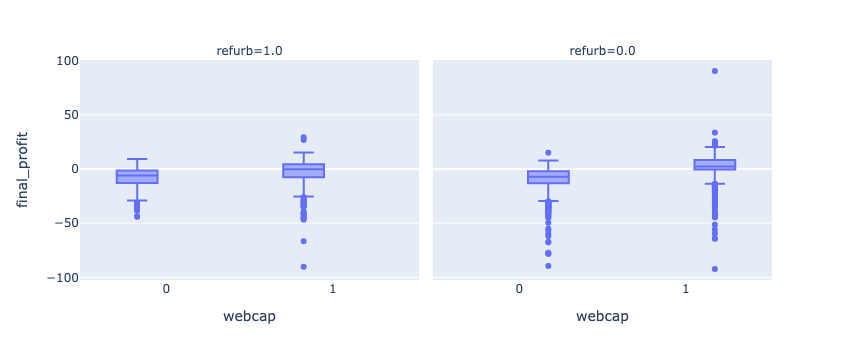

In [47]:
px.box(
    data_frame=dfc,
    x='webcap',
    y='final_profit',
    facet_col='refurb',
)

# 

# Header

# *Notes*

### Testing profit calculation algorithm

In [ ]:
## Expected profits (present value) for each customer if we don't do anything
prom_exp_profit(
        periods=6, 
        revenue=100, 
        cost=40,
        churn_p_sq=0.2,
        churn_p_prom=0.1,
        disc=0.0,
    ),

### Testing weird behavior calculating predictions

#### Model 1

In [ ]:
## Works
x = dfm1_test.loc[1099785:1099979, m1f]
m1.predict(x)

## Doesn't work
x = dfm1_test.loc[1099971:1099979, m1f]
m1.predict(x)

## Doesn't work
x = dfm1_test.loc[1099971:1099979, m1f].values
m1.predict(x)

## Doesn't work
x_matrix = sm.add_constant(dfm1_test.loc[1099971:1099979, m1f])
m1.predict(x_matrix)

#### Model 2

In [ ]:
## Works
x = dfm2_test.loc[1099785:1099979, m2f]
m2.predict(x)

## Doesn't work
x = dfm2_test.loc[1099971:1099979, m2f]
m2.predict(x)

## Doesn't work
x = dfm2_test.loc[1099971:1099979, m2f].values
m2.predict(x)

## Doesn't work
x_matrix = sm.add_constant(dfm2_test.loc[1099971:1099979, m2f])
m2.predict(x_matrix)

### Old dict

In [ ]:
## Promotions dictionary
proms = {
    
    ## Selecting out clients who might have lower churn if they get a customer service call asking them about their service and notifying them of either/both "block calls from unknown numbers" setting and referral promotion.
    'Customer Service Call': {
        'selection': (dfc['m1_pred_prob_grade'] == 1),
    },
    
    ## Selecting out clients who might have lower churn if they get inactive users removed
    'Prune Inactive Users': {
        'selection': (dfc['m1_pred_prob_grade'] == 1) & (dfc['uniqsubs'] - dfc['actvsubs'] > 0)
    },
    
    ## Selecting out clients who might have lower churn if they get a new device
    'New Phone': { # These people are grade 1 churn risks with a refurbished, old, or non-web device
        'selection': (dfc['m1_pred_prob_grade'] == 1) & ((dfc['refurb'] == 1) | (dfc['eqpdays'] >= dfc['eqpdays'].quantile(0.75)) | (dfc['webcap'] == 0)),
    },
}

## Model 2
### Logistic regression with regularization

##### Model dataset

In [ ]:
dfm2_train = df_train.copy()
dfm2_test = df_test.copy()

##### Model label and features

In [ ]:
## Label
m2l = 'churndep'

## Features
m2f = [
    # 'calibrat',
    # 'churn',
    # 'churndep',
    'revenue',
    'mou',
    'recchrge',
    'directas',
    'overage',
    'roam',
    'changem',
    'changer',
    'dropvce',
    'blckvce',
    'unansvce',
    'custcare',
    'threeway',
    'mourec',
    'outcalls',
    'incalls',
    'peakvce',
    'opeakvce',
    'dropblk',
    'callfwdv',
    'callwait',
    'months',
    'uniqsubs',
    'actvsubs',
    'phones',
    'models',
    'eqpdays',
    'age1',
    'age2',
    'children',
    'credita',
    'creditaa',
    'prizmrur',
    'prizmub',
    'prizmtwn',
    'refurb',
    'webcap',
    'truck',
    'rv',
    'occprof',
    'occcler',
    'occcrft',
    'occstud',
    'occhmkr',
    'occret',
    'occself',
    'ownrent',
    'marryun',
    'marryyes',
    'mailord',
    'mailres',
    'mailflag',
    'travel',
    'pcown',
    'creditcd',
    'retcalls',
    'retaccpt',
    'newcelly',
    'newcelln',
    'refer',
    'incmiss',
    'income',
    'mcycle',
    'setprcm',
    'setprc',
    'retcall',
    'rec_ntile',
    'freq_ntile',
    'mon_ntile',
]

##### Model training

In [ ]:
m2 = logit_reg(
    a=dfm2_train[m2l],
    b=dfm2_train[m2f],
    alpha=3,
)

##### Model coefficients

In [ ]:
m2.summary()

In [ ]:
dfm2_or = odds_ratios(m2)
dfm2_or

##### Features selection

In [ ]:
## Adding the standard deviation column to the odds ratios dataframe
dfm2_or = dfm2_or.join(
    dfi.loc[:, 'std']
)

## Operation between resulting odds ratios and standard deviation
dfm2_or['or**std'] = dfm2_or['Odds ratios']**dfm2_or['std']

## Calculating absolute difference between resulting column and 1
dfm2_or['diff_or**std'] = abs(1 - dfm2_or['or**std'])

## Ranking results
dfm2_or['rank'] = dfm2_or['diff_or**std'].rank(ascending=False)
dfm2_or.sort_values(by='rank', inplace=True, ascending=True)

##### Predictions

In [ ]:
## Churn predicted probability
dfm2_test['m2_pred_prob'] = m2.predict(dfm2_test[m2f])

## Classifying churners in groups
dfm2_test['m2_pred_prob_grade'] = 10 - ntile(dfm2_test['m2_pred_prob'], 10)

##### 

## Model 3
### Logistic regression with features selected from model 1

##### Model dataset

In [ ]:
dfm3_train = df_train.copy()
dfm3_test = df_test.copy()

##### Model label and features

In [ ]:
## Label
m3l = 'churndep'

## Features
m3f = [
    # 'calibrat',
    # 'churn',
    # 'churndep',
    # 'revenue',
    'mou',
    # 'recchrge',
    # 'directas',
    # 'overage',
    # 'roam',
    'changem',
    'changer',
    'dropvce',
    # 'blckvce',
    # 'unansvce',
    # 'custcare',
    # 'threeway',
    # 'mourec',
    # 'outcalls',
    # 'incalls',
    # 'peakvce',
    # 'opeakvce',
    # 'dropblk',
    # 'callfwdv',
    # 'callwait',
    'months',
    'uniqsubs',
    'actvsubs',
    # 'phones',
    # 'models',
    'eqpdays',
    # 'age1',
    # 'age2',
    # 'children',
    # 'credita',
    'creditaa',
    # 'prizmrur',
    # 'prizmub',
    # 'prizmtwn',
    # 'refurb',
    # 'webcap',
    # 'truck',
    # 'rv',
    # 'occprof',
    # 'occcler',
    # 'occcrft',
    # 'occstud',
    # 'occhmkr',
    # 'occret',
    # 'occself',
    # 'ownrent',
    # 'marryun',
    # 'marryyes',
    # 'mailord',
    # 'mailres',
    # 'mailflag',
    # 'travel',
    # 'pcown',
    # 'creditcd',
    # 'retcalls',
    # 'retaccpt',
    # 'newcelly',
    # 'newcelln',
    # 'refer',
    # 'incmiss',
    # 'income',
    # 'mcycle',
    # 'setprcm',
    # 'setprc',
    'retcall',
    # 'rec_ntile',
    # 'freq_ntile',
    # 'mon_ntile',
]

##### Model training

In [ ]:
m3 = logit_reg(
    a=dfm3_train[m3l],
    b=dfm3_train[m3f],
    alpha=0,
)

##### Model coefficients

In [ ]:
m3.summary()

In [ ]:
odds_ratios(m3)

##### Model predictions

In [ ]:
## Churn predicted probability
dfm3_test['m3_pred_prob'] = m3.predict(dfm3_test[m3f])

## Classifying churners in groups
dfm3_test['m3_pred_prob_grade'] = 10 - ntile(dfm3_test['m3_pred_prob'], 10)

## 

---

---